# **ORATS SPY Options Chain EDA**

This notebook keeps the original EDA intent while sourcing QC diagnostics from
the pipeline artifact `qc_summary.json` instead of re-implementing manual checks
in notebook cells.

In [91]:
%load_ext autoreload
%autoreload 2

import json
from datetime import date

import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import yfinance as yf

from volatility_trading.config.paths import PROC_ORATS_OPTIONS_CHAIN
from volatility_trading.datasets import (
    options_chain_wide_to_long,
    read_daily_features,
    scan_options_chain,
)
from volatility_trading.etl.orats.qc.plotting import (
    plot_avg_volume_by_delta,
    plot_liquidity_by_dte,
    plot_smiles_by_delta,
    plot_term_structures_by_delta,
)
from volatility_trading.iv_surface.term_structure import pick_closest_dte

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Read SPY Options data

We analyze the whole chain from `2007-01-01` to `2025-12-31` and keep contracts
inside a broad tradable region.

In [68]:
TICKER = "SPY"

start = date(2007, 1, 1)
end = date(2025, 12, 5)

delta_min = 0.01
delta_max = 0.99
dte_min = 5
dte_max = 252

lf = scan_options_chain(TICKER)
lf = lf.filter(
    pl.col("trade_date").is_between(start, end),
    pl.col("call_delta").abs().is_between(delta_min, delta_max),
    pl.col("put_delta").abs().is_between(delta_min, delta_max),
    pl.col("dte").is_between(dte_min, dte_max),
)

df = lf.collect()
df_long = options_chain_wide_to_long(df).collect()

df

ticker,trade_date,expiry_date,dte,yte,underlying_price,spot_price,strike,call_volume,put_volume,call_open_interest,put_open_interest,call_bid_price,call_mid_price,call_model_price,call_ask_price,call_rel_spread,put_bid_price,put_mid_price,put_model_price,put_ask_price,put_rel_spread,smoothed_iv,call_mid_iv,put_mid_iv,call_delta,call_gamma,call_theta,call_vega,call_rho,put_delta,put_gamma,put_theta,put_vega,put_rho,risk_free_rate,dividend_yield
str,date,date,i64,f64,f64,f64,f64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""SPY""",2007-01-03,2007-01-20,17,0.04658,141.37,141.37,132.0,0,11,1237,18579,9.6,9.7,9.74,9.8,0.020619,0.0,0.05,0.03,0.1,2.0,0.156813,0.09432,0.09613,0.983301,0.008686,-0.025484,0.012315,0.060232,-0.016699,0.008686,-0.025484,0.012315,0.060232,0.0484,0.0
"""SPY""",2007-01-03,2007-01-20,17,0.04658,141.37,141.37,133.0,0,70,1921,15443,8.7,8.75,8.77,8.8,0.011429,0.05,0.075,0.06,0.1,0.666667,0.158524,0.08551,0.16521,0.970073,0.014062,-0.029174,0.022321,0.059813,-0.029927,0.014062,-0.029174,0.022321,0.059813,0.0484,0.0
"""SPY""",2007-01-03,2007-01-20,17,0.04658,141.37,141.37,134.0,22,0,1447,22032,7.7,7.8,7.8,7.9,0.025641,0.05,0.1,0.09,0.15,1.0,0.155324,0.09083,0.15615,0.955052,0.020038,-0.032558,0.031546,0.059273,-0.044948,0.020038,-0.032558,0.031546,0.059273,0.0484,0.0
"""SPY""",2007-01-03,2007-01-20,17,0.04658,141.37,141.37,135.0,63,543,2785,35003,6.7,6.8,6.85,6.9,0.029412,0.1,0.125,0.13,0.15,0.4,0.1511,0.08124,0.14818,0.934797,0.02765,-0.036315,0.037223,0.058383,-0.065203,0.02765,-0.036315,0.037223,0.058383,0.0484,0.0
"""SPY""",2007-01-03,2007-01-20,17,0.04658,141.37,141.37,136.0,18,1741,1681,40035,5.8,5.85,5.91,5.9,0.017094,0.15,0.175,0.19,0.2,0.285714,0.145614,0.13073,0.1416,0.908534,0.037099,-0.040146,0.04943,0.0570904,-0.091466,0.037099,-0.040146,0.04943,0.0570904,0.0484,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""SPY""",2025-12-05,2026-06-30,207,0.56712,685.61,685.61,850.0,0,0,202,0,0.48,0.49,0.49,0.5,0.040816,163.16,164.63,164.39,166.1,0.017858,0.126529,0.12681,0.12121,0.020504,0.000756,-0.008903,0.265688,0.07697,-0.979496,0.000756,-0.008903,0.265688,0.07697,0.036,0.013382
"""SPY""",2025-12-05,2026-06-30,207,0.56712,685.61,685.61,855.0,9,0,50,0,0.42,0.425,0.43,0.43,0.023529,168.15,169.72,169.39,171.29,0.018501,0.127016,0.12735,0.12484,0.017974,0.000673,-0.007968,0.212274,0.067501,-0.982026,0.000673,-0.007968,0.212274,0.067501,0.036,0.013382
"""SPY""",2025-12-05,2026-06-30,207,0.56712,685.61,685.61,860.0,0,0,49,0,0.37,0.375,0.37,0.38,0.026667,173.14,174.61,174.39,176.08,0.016838,0.127451,0.12803,0.1259,0.015766,0.000599,-0.007123,0.214644,0.059233,-0.984234,0.000599,-0.007123,0.214644,0.059233,0.036,0.013382


In [70]:
daily_features = read_daily_features(TICKER)
daily_features = daily_features.filter(
    pl.col("trade_date").is_between(start, end)
)
daily_features = daily_features.to_pandas().set_index("trade_date")
daily_features

,ticker,iv_10d,iv_20d,iv_30d,iv_60d,iv_90d,iv_6m,iv_1y,iv_dlt25_10d,iv_dlt25_20d,...,hv_intra_1d,hv_intra_5d,hv_intra_10d,hv_intra_20d,hv_intra_30d,hv_intra_60d,hv_intra_90d,hv_intra_100d,hv_intra_120d,hv_intra_252d
trade_date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,SPY,0.101635,0.102469,0.104870,0.117420,0.124077,0.120905,0.119971,0.091543,0.092130,...,0.1550,0.0966,0.0886,0.0835,0.0884,0.0871,0.1161,0.1138,0.1179,0.1213
2007-01-04,SPY,0.092746,0.094150,0.097141,0.109366,0.122466,0.120715,0.122350,0.085077,0.085406,...,0.0993,0.1002,0.0905,0.0825,0.0899,0.0878,0.1165,0.1138,0.1168,0.1212
2007-01-05,SPY,0.107158,0.107713,0.108645,0.121309,0.121143,0.123434,0.102399,0.095921,0.096610,...,0.1029,0.1042,0.0915,0.0845,0.0913,0.0886,0.1168,0.1141,0.1167,0.1212
2007-01-08,SPY,0.104130,0.104633,0.105134,0.118536,0.119770,0.120721,0.122504,0.093455,0.091858,...,0.0901,0.1093,0.0948,0.0864,0.0926,0.0891,0.1168,0.1140,0.1168,0.1213
2007-01-09,SPY,0.107480,0.107693,0.107879,0.114870,0.126901,0.121019,0.110381,0.101403,0.099474,...,0.0816,0.1088,0.0947,0.0860,0.0934,0.0891,0.1168,0.1135,0.1163,0.1211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-12-01,SPY,0.131834,0.147691,0.131681,0.144273,0.150576,0.161976,0.170348,0.115265,0.129748,...,0.0738,0.1336,0.1873,0.1658,0.1476,0.1343,0.1247,0.1206,0.1173,0.1930
2025-12-02,SPY,0.132815,0.139302,0.132822,0.143952,0.149011,0.159100,0.166644,0.116351,0.125871,...,0.0652,0.1089,0.1788,0.1654,0.1464,0.1344,0.1248,0.1206,0.1172,0.1930
2025-12-03,SPY,0.126530,0.133172,0.130965,0.142168,0.147754,0.155886,0.169044,0.113659,0.118831,...,0.0800,0.0774,0.1737,0.1635,0.1469,0.1346,0.1250,0.1208,0.1172,0.1930


# Load QC summary artifact

The checks below are read from the quality checks summary after running `orats-api-download --config config/orats_api_download.yml`
```

In [95]:
qc_summary_path = (
     PROC_ORATS_OPTIONS_CHAIN / f"underlying={TICKER}" / "qc_summary.json"
)

with qc_summary_path.open(encoding="utf-8") as f:
    qc_summary = json.load(f)

qc_by_name = {row["name"]: row for row in qc_summary}


def qc_table(names: list[str]) -> pl.DataFrame:
    """Return a compact QC table for check names that exist."""
    rows: list[dict[str, object]] = []
    for name in names:
        row = qc_by_name.get(name)
        if row is None:
            continue
        rows.append(
            {
                "name": row["name"],
                "severity": row["severity"],
                "grade": row["grade"],
                "passed": row["passed"],
                "n_rows": row.get("n_rows"),
                "n_units": row.get("n_units"),
                "n_viol": row.get("n_viol"),
                "viol_rate": row.get("viol_rate"),
            }
        )
    return pl.DataFrame(rows).sort(["severity", "name"])


def qc_top_buckets(names: str | list[str]) -> pl.DataFrame:
    """Return top bucket diagnostics for one or many SOFT checks."""
    if isinstance(names, str):
        row = qc_by_name.get(names, {})
        top_buckets = row.get("details", {}).get("top_buckets", [])
        return pl.DataFrame(top_buckets)

    rows: list[dict[str, object]] = []
    for name in names:
        row = qc_by_name.get(name, {})
        top_buckets = row.get("details", {}).get("top_buckets", [])
        for bucket in top_buckets:
            rows.append({"name": name, **bucket})
    return pl.DataFrame(rows)


def qc_thresholds(names: str | list[str]) -> dict[str, object] | pl.DataFrame:
    """Return thresholds for one or many QC check names."""
    if isinstance(names, str):
        return qc_by_name.get(names, {}).get("details", {}).get("thresholds", {})

    rows: list[dict[str, object]] = []
    for name in names:
        thresholds = qc_by_name.get(name, {}).get("details", {}).get("thresholds", {})
        if thresholds:
            rows.append({"name": name, **thresholds})
    return pl.DataFrame(rows).sort("name") if rows else pl.DataFrame()


def qc_details(names: str | list[str]) -> dict:
    """Return details payload for one QC check or a name->details mapping."""
    if isinstance(names, str):
        return qc_by_name.get(names, {}).get("details", {})
    return {name: qc_by_name.get(name, {}).get("details", {}) for name in names}


def first_existing(*candidates: str) -> str | None:
    """Return first check name found in qc_summary."""
    for c in candidates:
        if c in qc_by_name:
            return c
    return None


def info_stats_metric(info_name: str, metric: str) -> pd.DataFrame:
    """Return one metric block from INFO core_numeric_stats."""
    stats = qc_details(info_name).get("stats", {})
    if metric not in stats:
        return pd.DataFrame()
    out = pd.DataFrame([stats[metric]])
    out.insert(0, "metric", metric)
    return out


len(qc_summary), qc_summary[3]

(68,
 {'name': 'negative_quotes',
  'severity': 'HARD',
  'grade': 'OK',
  'passed': True,
  'n_rows': 15073890,
  'n_units': None,
  'n_viol': 0,
  'viol_rate': 0.0,
  'details': {}})

# **Basic Checks**

Hard structural checks + calendar-level dataset checks from the QC summary.

In [4]:
basic_checks = qc_table(
    [
        "keys_not_null",
    ]
)
basic_checks

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,null,i64,f64
"""keys_not_null""","""HARD""","""OK""",true,15073890,null,0,0.0


In [5]:
basic_checks = qc_table(
    [
        "keys_not_null",
        "trade_date_leq_expiry_date",
        "GLOBAL_missing_sessions_xnys",
        "GLOBAL_non_trading_dates_present_xnys",
    ]
)
basic_checks

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,i64,i64,f64
"""keys_not_null""","""HARD""","""OK""",true,15073890,null,0,0.0
"""trade_date_leq_expiry_date""","""HARD""","""OK""",true,15073890,null,0,0.0
"""GLOBAL_missing_sessions_xnys""","""SOFT""","""OK""",true,15073890,4763,0,0.0
"""GLOBAL_non_trading_dates_prese…","""SOFT""","""MILD""",true,15073890,4764,1,0.00021


In [6]:
missing_sessions = qc_details("GLOBAL_missing_sessions_xnys").get("missing_dates", [])
non_trading = qc_details("GLOBAL_non_trading_dates_present_xnys").get("extra_dates", [])

print("Missing XNYS sessions:", len(missing_sessions))
print("Non-trading dates present:", len(non_trading))
print("Sample missing sessions:", missing_sessions[:5])
print("Sample non-trading dates:", non_trading[:5])

Missing XNYS sessions: 0
Non-trading dates present: 1
Sample missing sessions: []
Sample non-trading dates: ['2018-12-05']


After investgiation the trading date `2018-12-05` coreesponds to George W bush memorial day where the NYSE was closed but here
the options market were still opened so we can assume that we can trade on this day.

In [7]:
df.filter(pl.col("trade_date") == pl.date(2018, 12, 5))

ticker,trade_date,expiry_date,dte,yte,underlying_price,spot_price,strike,call_volume,put_volume,call_open_interest,put_open_interest,call_bid_price,call_mid_price,call_model_price,call_ask_price,call_rel_spread,put_bid_price,put_mid_price,put_model_price,put_ask_price,put_rel_spread,smoothed_iv,call_mid_iv,put_mid_iv,call_delta,call_gamma,call_theta,call_vega,call_rho,put_delta,put_gamma,put_theta,put_vega,put_rho,risk_free_rate,dividend_yield
str,date,date,i64,f64,f64,f64,f64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""SPY""",2018-12-05,2018-12-10,5,0.0137,270.32,270.32,240.0,0,682,4,1442,30.11,30.47,30.5,30.83,0.02363,0.11,0.115,0.06,0.12,0.086957,0.459215,0.31184,0.50244,0.98811,0.0021333,-0.06793,0.009274,0.032421,-0.01189,0.0021333,-0.06793,0.009274,0.032421,0.0237,0.0
"""SPY""",2018-12-05,2018-12-10,5,0.0137,270.32,270.32,245.0,0,1340,14,1356,25.14,25.5,25.57,25.86,0.028235,0.14,0.145,0.13,0.15,0.068966,0.437442,0.27153,0.44393,0.97515,0.004205,-0.10358,0.017665,0.032616,-0.02485,0.004205,-0.10358,0.017665,0.032616,0.0237,0.0
"""SPY""",2018-12-05,2018-12-10,5,0.0137,270.32,270.32,246.0,0,41,0,0,24.15,24.505,24.6,24.86,0.028974,0.14,0.145,0.16,0.15,0.068966,0.434821,0.26258,0.42852,0.970862,0.004833,-0.114483,0.021471,0.032591,-0.029138,0.004833,-0.114483,0.021471,0.032591,0.0237,0.0
"""SPY""",2018-12-05,2018-12-10,5,0.0137,270.32,270.32,247.0,0,51,0,1,23.15,23.51,23.62,23.87,0.030625,0.15,0.155,0.18,0.16,0.064516,0.428644,0.25504,0.41758,0.96714,0.005421,-0.122714,0.025743,0.0325869,-0.03286,0.005421,-0.122714,0.025743,0.0325869,0.0237,0.0
"""SPY""",2018-12-05,2018-12-10,5,0.0137,270.32,270.32,248.0,0,66,0,0,22.16,22.52,22.65,22.88,0.031972,0.15,0.16,0.21,0.17,0.125,0.424085,0.24742,0.40435,0.962074,0.006156,-0.13381,0.025806,0.032532,-0.037926,0.006156,-0.13381,0.025806,0.032532,0.0237,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""SPY""",2018-12-05,2019-06-28,205,0.56164,270.32,270.32,320.0,11,0,638,11,0.39,0.43,0.55,0.47,0.186047,49.98,50.695,53.69,51.41,0.028208,0.132639,0.12668,0.0,0.050525,0.003903,-0.007727,0.206732,0.072968,-0.949475,0.003903,-0.007727,0.206732,0.072968,0.0271,0.0
"""SPY""",2018-12-05,2019-06-28,205,0.56164,270.32,270.32,325.0,0,0,298,0,0.27,0.305,0.35,0.34,0.229508,54.97,55.685,58.69,56.4,0.02568,0.131278,0.1281,0.0,0.034592,0.002902,-0.005588,0.145047,0.050072,-0.965408,0.002902,-0.005588,0.145047,0.050072,0.0271,0.0
"""SPY""",2018-12-05,2019-06-28,205,0.56164,270.32,270.32,330.0,0,0,2510,5,0.2,0.235,0.22,0.27,0.297872,59.96,60.675,63.69,61.39,0.023568,0.130202,0.13111,0.0,0.023325,0.002105,-0.003963,0.121492,0.0338733,-0.976675,0.002105,-0.003963,0.121492,0.0338733,0.0271,0.0


As you can see contracts were traded that day.

# **Days-to-expiry check**


Here a `HARD` error will be that the current `trade_date` is larger than the exipiry
whihc is imposisble as at the latest the trade_date can match the maturity on the expiry date but beyind it is impossible.

We alos check the distributuon of the `dte` column expecting dte ranging from the tradebale filters we have applied.

In [8]:
dte_checks = qc_table(["trade_date_leq_expiry_date"])
dte_checks

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,null,i64,f64
"""trade_date_leq_expiry_date""","""HARD""","""OK""",true,15073890,null,0,0.0


In [9]:
global_dte_stats = info_stats_metric("GLOBAL_core_numeric_stats", "dte")
print("GLOBAL DTE stats")
display(global_dte_stats)

GLOBAL DTE stats


,metric,null_rate,n_nonnull,min,max,mean,std,median,q_0.00,q_0.01,q_0.05,q_0.50,q_0.95,q_0.99,q_1.00
0,dte,0.0,15073890,1.0,252.0,67.379465,68.617457,36.0,1.0,1.0,3.0,36.0,217.0,245.0,252.0


# **Quote sanity checks**

Here we separate quote checks into 3 groups:

1. **Hard data errors** (drop-candidate rows)
   - `negative_quotes`: bid or ask below zero (impossible market quotes)
   - `crossed_market`: bid above ask (invalid quote state)
   - `bid_ask_sane`: hard guardrail summary for bid/ask consistency

2. **Suspicious but often explainable microstructure cases** (investigate first)
   - `locked_market`: bid equals ask
   - `one_sided_quotes`: no bid with positive ask
   These can happen, especially in low-liquidity wings or near close.

3. **Spread quality diagnostics**
   - `wide_spread` and `very_wide_spread`
   Not always a data error, but a trading-quality warning.
   In practice, we care whether they cluster outside the tradable ROI.

## 1) Hard quote errors (non-negotiable)

Policy:
- If these appear materially, treat affected rows as invalid candidates.
- Expected outcome in clean data: near-zero violation rates.

In [10]:
hard_quote_checks = qc_table(
    [
        "bid_ask_sane",
        "negative_quotes",
        "crossed_market",
    ]
)
hard_quote_checks

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,null,i64,f64
"""bid_ask_sane""","""HARD""","""OK""",true,15073890,null,0,0.0
"""crossed_market""","""HARD""","""OK""",true,15073890,null,0,0.0
"""negative_quotes""","""HARD""","""OK""",true,15073890,null,0,0.0


## 2) Locked and one-sided quotes (investigate, then decide)

Policy:
- Keep as soft flags first.
- Escalate only if rates are high in ROI (10-60 DTE, 10-90 delta).

In [11]:
microstructure_quote_checks = qc_table(
    [
        "GLOBAL_locked_market_C",
        "GLOBAL_locked_market_P",
        "ROI_locked_market_C",
        "ROI_locked_market_P",
        "GLOBAL_one_sided_quotes_C",
        "GLOBAL_one_sided_quotes_P",
        "ROI_one_sided_quotes_C",
        "ROI_one_sided_quotes_P",
    ]
)
microstructure_quote_checks

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,null,i64,f64
"""GLOBAL_locked_market_C""","""SOFT""","""OK""",true,15073890,null,29788,0.001976
"""GLOBAL_locked_market_P""","""SOFT""","""OK""",true,15073890,null,24731,0.001641
"""GLOBAL_one_sided_quotes_C""","""SOFT""","""WARN""",false,15073890,null,539559,0.035794
"""GLOBAL_one_sided_quotes_P""","""SOFT""","""MILD""",true,15073890,null,204344,0.013556
"""ROI_locked_market_C""","""SOFT""","""OK""",true,2678530,null,63,0.000024
"""ROI_locked_market_P""","""SOFT""","""OK""",true,2678530,null,103,0.000038
"""ROI_one_sided_quotes_C""","""SOFT""","""OK""",true,2678530,null,22,0.000008
"""ROI_one_sided_quotes_P""","""SOFT""","""OK""",true,2678530,null,10,0.000004


In [46]:
qc_top_buckets("GLOBAL_one_sided_quotes_P")

dte_bucket,delta_bucket,n_viol,n_rows,viol_rate_bucket,viol_share,row_share
str,str,i64,i64,f64,f64,f64
"""(0, 10]""","""(-inf, 0]""",143548,310018,0.463031,0.702482,0.041133
"""(10, 30]""","""(-inf, 0]""",14386,111212,0.129357,0.070401,0.014756
"""(0, 10]""","""(0, 0.05]""",29371,386997,0.075895,0.143733,0.051347
"""(30, 60]""","""(-inf, 0]""",592,21540,0.027484,0.002897,0.002858
"""(30, 60]""","""(0, 0.05]""",5684,251712,0.022581,0.027816,0.033397


In [47]:
qc_top_buckets("ROI_one_sided_quotes_P")

dte_bucket,delta_bucket,n_viol,n_rows,viol_rate_bucket,viol_share,row_share
str,str,i64,i64,f64,f64,f64
"""(10, 30]""","""(0.3, 0.7]""",5,275072,0.000018,0.5,0.205391
"""(10, 30]""","""(0.1, 0.3]""",2,285255,0.000007,0.2,0.212994
"""(10, 30]""","""(0.7, 0.9]""",1,149096,0.000007,0.1,0.111327
"""(30, 60]""","""(0.1, 0.3]""",1,233854,0.000004,0.1,0.174614
"""(30, 60]""","""(0.3, 0.7]""",1,242656,0.000004,0.1,0.181186


## 3) Spread diagnostics (execution quality)

Policy:
- Wide spreads are expected to be much worse in wings / short DTE.
- We focus on ROI behavior to assess strategy impact.

In [14]:
spread_quote_checks = qc_table(
    [
        "GLOBAL_wide_spread_C",
        "GLOBAL_wide_spread_P",
        "ROI_wide_spread_C",
        "ROI_wide_spread_P",
        "GLOBAL_very_wide_spread_C",
        "GLOBAL_very_wide_spread_P",
        "ROI_very_wide_spread_C",
        "ROI_very_wide_spread_P",
    ]
)
spread_quote_checks

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,null,i64,f64
"""GLOBAL_very_wide_spread_C""","""SOFT""","""OK""",true,15073890,null,0,0.0
"""GLOBAL_very_wide_spread_P""","""SOFT""","""OK""",true,15073890,null,0,0.0
"""GLOBAL_wide_spread_C""","""SOFT""","""OK""",true,15073890,null,149886,0.009943
"""GLOBAL_wide_spread_P""","""SOFT""","""OK""",true,15073890,null,41760,0.00277
"""ROI_very_wide_spread_C""","""SOFT""","""OK""",true,2678530,null,0,0.0
"""ROI_very_wide_spread_P""","""SOFT""","""OK""",true,2678530,null,0,0.0
"""ROI_wide_spread_C""","""SOFT""","""OK""",true,2678530,null,79,0.000029
"""ROI_wide_spread_P""","""SOFT""","""OK""",true,2678530,null,234,0.000087


In [44]:
qc_top_buckets("GLOBAL_wide_spread_P")

dte_bucket,delta_bucket,n_viol,n_rows,viol_rate_bucket,viol_share,row_share
str,str,i64,i64,f64,f64,f64
"""(10, 30]""","""(-inf, 0]""",6665,111212,0.059931,0.159602,0.014756
"""(30, 60]""","""(-inf, 0]""",747,21540,0.03468,0.017888,0.002858
"""(0, 10]""","""(-inf, 0]""",9916,310018,0.031985,0.237452,0.041133
"""(30, 60]""","""(0, 0.05]""",7670,251712,0.030471,0.183669,0.033397
"""(10, 30]""","""(0, 0.05]""",9991,393513,0.025389,0.239248,0.052211


In [45]:
qc_top_buckets("ROI_wide_spread_P")

dte_bucket,delta_bucket,n_viol,n_rows,viol_rate_bucket,viol_share,row_share
str,str,i64,i64,f64,f64,f64
"""(30, 60]""","""(0.1, 0.3]""",118,233854,0.000505,0.504274,0.174614
"""(10, 30]""","""(0.1, 0.3]""",74,285255,0.000259,0.316239,0.212994
"""(10, 30]""","""(0.3, 0.7]""",21,275072,0.000076,0.089744,0.205391
"""(0, 10]""","""(0.3, 0.7]""",1,13349,0.000075,0.004274,0.009967
"""(0, 10]""","""(0.1, 0.3]""",1,14087,0.000071,0.004274,0.010518


# **Volume & Open Interest Checks**

Here we separate volume/OI checks into 3 groups:

1. **Hard data errors** (drop-candidate rows)
   - `negative_vol_oi`: negative traded volume or open interest (invalid values)

2. **Soft consistency diagnostics** (investigate first)
   - `zero_vol_pos_oi`: positive OI with zero volume
   - `pos_vol_zero_oi`: positive volume with zero OI
   These are often explainable by microstructure/timing but can cluster in weak
   quality regions.

3. **INFO liquidity diagnostics**
   - `volume_oi_metrics` summaries for GLOBAL and ROI scopes
   Not a pass/fail rule; used to profile tradability and market depth.

In [17]:
hard_vol_oi_checks = qc_table(["negative_vol_oi"])
hard_vol_oi_checks

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,null,i64,f64
"""negative_vol_oi""","""HARD""","""OK""",true,15073890,null,0,0.0
"""GLOBAL_pos_vol_zero_oi_C""","""SOFT""","""MILD""",true,15073890,null,193694,0.01285
"""GLOBAL_pos_vol_zero_oi_P""","""SOFT""","""MILD""",true,15073890,null,242990,0.01612
"""GLOBAL_zero_vol_pos_oi_C""","""SOFT""","""MILD""",true,15073890,null,1873603,0.124295
"""GLOBAL_zero_vol_pos_oi_P""","""SOFT""","""MILD""",true,15073890,null,1260351,0.083612
"""ROI_pos_vol_zero_oi_C""","""SOFT""","""MILD""",true,2678530,null,73999,0.027627
"""ROI_pos_vol_zero_oi_P""","""SOFT""","""MILD""",true,2678530,null,80056,0.029888
"""ROI_zero_vol_pos_oi_C""","""SOFT""","""OK""",true,2678530,null,104126,0.038874
"""ROI_zero_vol_pos_oi_P""","""SOFT""","""OK""",true,2678530,null,51196,0.019113


In [18]:
soft_vol_oi_checks = qc_table(
    [
        "GLOBAL_zero_vol_pos_oi_C",
        "GLOBAL_zero_vol_pos_oi_P",
        "ROI_zero_vol_pos_oi_C",
        "ROI_zero_vol_pos_oi_P",
        "GLOBAL_pos_vol_zero_oi_C",
        "GLOBAL_pos_vol_zero_oi_P",
        "ROI_pos_vol_zero_oi_C",
        "ROI_pos_vol_zero_oi_P",
    ]
)
soft_vol_oi_checks

,n_rows,volume_null_rate,volume_zero_rate,oi_null_rate,oi_zero_rate
GLOBAL_volume_oi_metrics,15073890,0.0,0.361542,0.0,0.182605
ROI_volume_oi_metrics,2678530,0.0,0.116327,0.0,0.115854


In [ ]:
vol_oi_metrics = pd.DataFrame(
    [
        qc_details("GLOBAL_volume_oi_metrics"),
        qc_details("ROI_volume_oi_metrics"),
    ],
    index=["GLOBAL_volume_oi_metrics", "ROI_volume_oi_metrics"],
)
vol_oi_metrics

In [42]:
qc_top_buckets("GLOBAL_zero_vol_pos_oi_P")

dte_bucket,delta_bucket,n_viol,n_rows,viol_rate_bucket,viol_share,row_share
str,str,i64,i64,f64,f64,f64
"""(180, inf]""","""(0.1, 0.3]""",105080,259346,0.405173,0.083374,0.03441
"""(60, 180]""","""(-inf, 0]""",4016,10030,0.400399,0.003186,0.001331
"""(180, inf]""","""(0.7, 0.9]""",36599,93024,0.393436,0.029039,0.012342
"""(180, inf]""","""(0, 0.05]""",8803,22831,0.385572,0.006985,0.003029
"""(180, inf]""","""(0.05, 0.1]""",21604,58636,0.368443,0.017141,0.00778


In [43]:
qc_top_buckets("GLOBAL_pos_vol_zero_oi_P")

dte_bucket,delta_bucket,n_viol,n_rows,viol_rate_bucket,viol_share,row_share
str,str,i64,i64,f64,f64,f64
"""(30, 60]""","""(0.3, 0.7]""",21339,242656,0.087939,0.087818,0.032196
"""(0, 10]""","""(0.95, 1]""",34470,459052,0.07509,0.141858,0.060907
"""(30, 60]""","""(0.1, 0.3]""",15410,233854,0.065896,0.063418,0.031028
"""(0, 10]""","""(0.9, 0.95]""",1982,31697,0.06253,0.008157,0.004206
"""(30, 60]""","""(0.7, 0.9]""",6867,118251,0.058071,0.02826,0.01569


# **Spot price sanity checks**

Spot consistency checks come from the QC summary; external price comparison
remains as EDA context.

Here we chekc that the spot price is the same for a given (ticker, trade_date, expiry_date, strike) bucket, namely that it is the same accros teh whole chain for a given day.

In the case of ETF/Stock options, there is no implied froward price whihc is store din the `underlying_price` column so the `spot_price` shoudl be the same as `underlying_price`.

In [20]:
spot_checks = qc_table(
    [
        "GLOBAL_spot_constant_per_trade_date",
        "GLOBAL_spot_equals_underlying_per_trade_date",
    ]
)
spot_checks

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,i64,i64,f64
"""GLOBAL_spot_constant_per_trade…","""SOFT""","""OK""",true,15073890,4764,0,0.0
"""GLOBAL_spot_equals_underlying_…","""SOFT""","""OK""",true,15073890,4764,0,0.0


## ORATS SPY vs Yahoo Finance Non-adjusted Closing Price

In ORATS, the options chain data provies a complete snapshot of the US equity options market 14 minutes before the close of trading each day.

Thus we should expect it to be very close to another data source, for instance Yahoo finance data which is reliable for a highly liquid ETF liek `SPY`.

In [48]:
spx_yf = yf.download(TICKER, start=start, end=end, auto_adjust=False)["Close"]
spx_yf = spx_yf.squeeze()
spx_yf.name = "spy_yf_close"

spx_orats = (
    df.group_by("trade_date")
    .agg(pl.col("spot_price").first().alias("spy_orats_spot"))
    .sort("trade_date")
    .to_pandas()
    .set_index("trade_date")
)

spx = pd.concat([spx_yf, spx_orats], axis=1).dropna()

diff = spx["spy_orats_spot"] - spx["spy_yf_close"]
rel_diff = diff / spx["spy_yf_close"]
corr = spx.corr().loc["spy_yf_close", "spy_orats_spot"]

print("Correlation (ORATS spot vs Yahoo close):", corr)
display(
    pd.DataFrame({"abs_diff": diff.abs(), "rel_diff": rel_diff}).describe(
        percentiles=[0.5, 0.9, 0.99]
    )
)

[*********************100%***********************]  1 of 1 completed


Correlation (ORATS spot vs Yahoo close): 0.9999912967080432


,abs_diff,rel_diff
count,4763.000000,4.763000e+03
mean,0.299487,2.111766e-05
std,0.543075,1.775399e-03
min,0.000000,-2.775000e-02
50%,0.100007,-2.776092e-09
90%,0.830001,1.340658e-03
99%,2.487591,4.921763e-03
max,7.410001,2.151342e-02


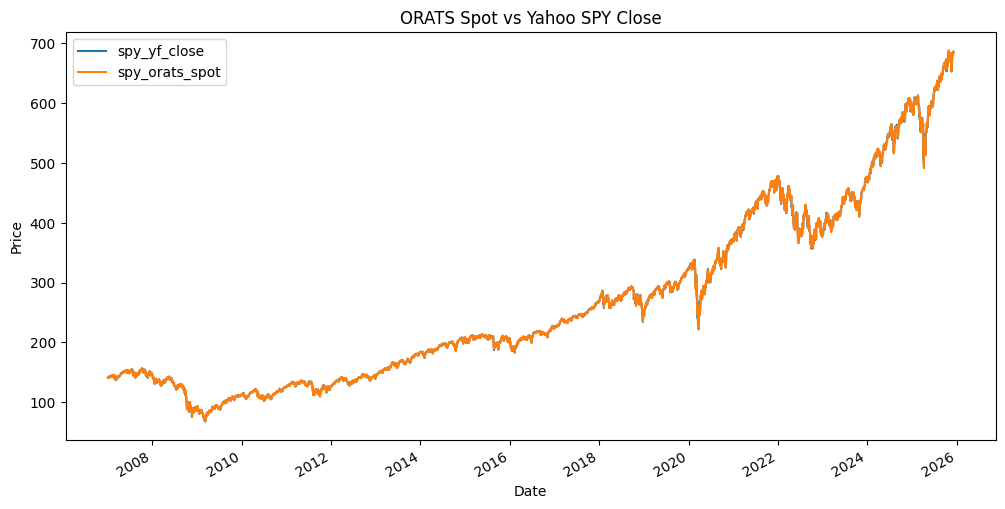

In [49]:
spx.plot(figsize=(12, 6))
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("ORATS Spot vs Yahoo SPY Close")
plt.show()

The two are very close to this confirms that the spot price data form ORATS is of good quality.

# **Risk free rate check**

In [51]:
rf_checks = qc_table(
    [
        "GLOBAL_unique_risk_free_rate_per_day_expiry",
    ]
)
rf_checks

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,i64,i64,f64
"""GLOBAL_unique_risk_free_rate_p…","""SOFT""","""OK""",true,15073890,79950,0,0.0


In [25]:
pd.DataFrame(
    [
        qc_details("GLOBAL_risk_free_rate_metrics"),
        qc_details("ROI_risk_free_rate_metrics"),
    ],
    index=["GLOBAL_risk_free_rate_metrics", "ROI_risk_free_rate_metrics"],
)

,n_rows,r_null_rate,r_min,r_max,r_mean,r_median
GLOBAL_risk_free_rate_metrics,15073890,0.0,0.0,0.0602,0.019690,0.0123
ROI_risk_free_rate_metrics,2678530,0.0,0.0,0.0602,0.018491,0.0110


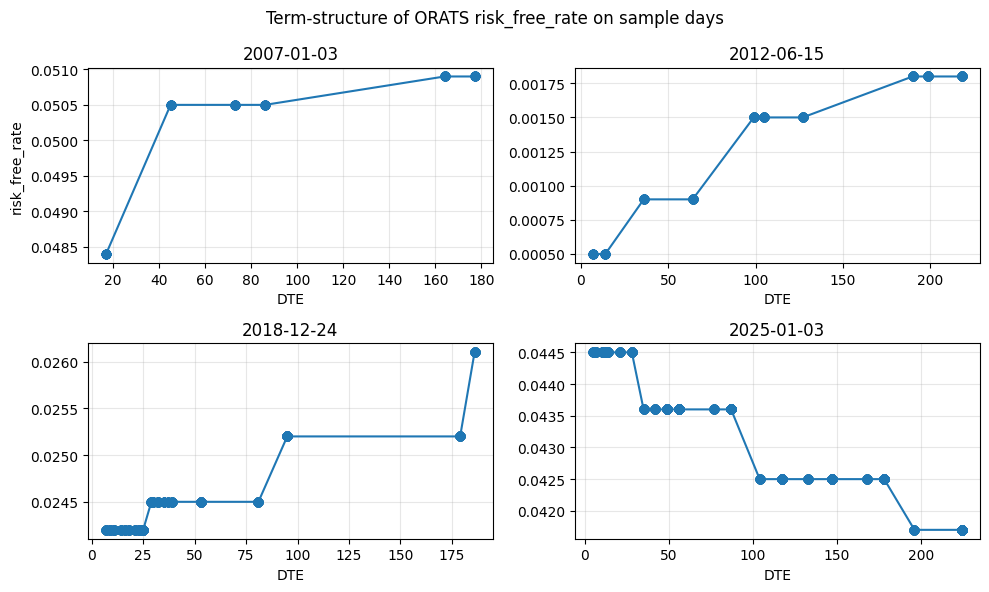

In [56]:
sample_days = [
    date(2007, 1, 3),
    date(2012, 6, 15),
    date(2018, 12, 24),
    date(2025, 1, 3),
]

nrows, ncols = 2, 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 6))
axes = axes.ravel()

for ax, day in zip(axes, sample_days, strict=False):
    sub_pd = (
        df.filter(pl.col("trade_date") == day)
        .select("dte", "risk_free_rate")
        .sort("dte")
        .to_pandas()
    )

    if sub_pd.empty:
        ax.set_axis_off()
        continue

    ax.plot(sub_pd["dte"], sub_pd["risk_free_rate"], marker="o", linestyle="-", label=str(day))
    ax.set_title(day.strftime("%Y-%m-%d"))
    ax.set_xlabel("DTE")
    ax.grid(alpha=0.3)

axes[0].set_ylabel("risk_free_rate")
fig.suptitle("Term-structure of ORATS risk_free_rate on sample days")
fig.tight_layout()
plt.show()

Here ORATS is using a 4-point yield curve per day, one for short maturities (less than 30 DTE) and one for int  (30 <= 90) and one for (90< dte <180) aned the last one beyond 180.

# **Implied Volatility Quality Checks**

In [26]:
iv_checks = qc_table(
    [
        "iv_non_negative",
        "GLOBAL_high_iv",
        "GLOBAL_very_high_iv",
    ]
)
iv_checks

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,null,i64,f64
"""iv_non_negative""","""HARD""","""OK""",true,15073890,null,0,0.0
"""GLOBAL_high_iv""","""SOFT""","""OK""",true,15073890,null,9378,0.000622
"""GLOBAL_very_high_iv""","""SOFT""","""OK""",true,15073890,null,0,0.0


In [27]:
display(info_stats_metric("GLOBAL_core_numeric_stats", "smoothed_iv"))
display(info_stats_metric("ROI_core_numeric_stats", "smoothed_iv"))

,metric,null_rate,n_nonnull,min,max,mean,std,median,q_0.00,q_0.01,q_0.05,q_0.50,q_0.95,q_0.99,q_1.00
0,smoothed_iv,0.0,15073890,0.01,1.95156,0.206395,0.098493,0.188129,0.01,0.072138,0.092514,0.188129,0.378108,0.520645,1.95156


,metric,null_rate,n_nonnull,min,max,mean,std,median,q_0.00,q_0.01,q_0.05,q_0.50,q_0.95,q_0.99,q_1.00
0,smoothed_iv,0.0,2678530,0.01,1.175964,0.190922,0.093534,0.170831,0.01,0.075908,0.09372,0.170831,0.346398,0.576113,1.175964


## Smile shape for 10, 30 and 60 DTE

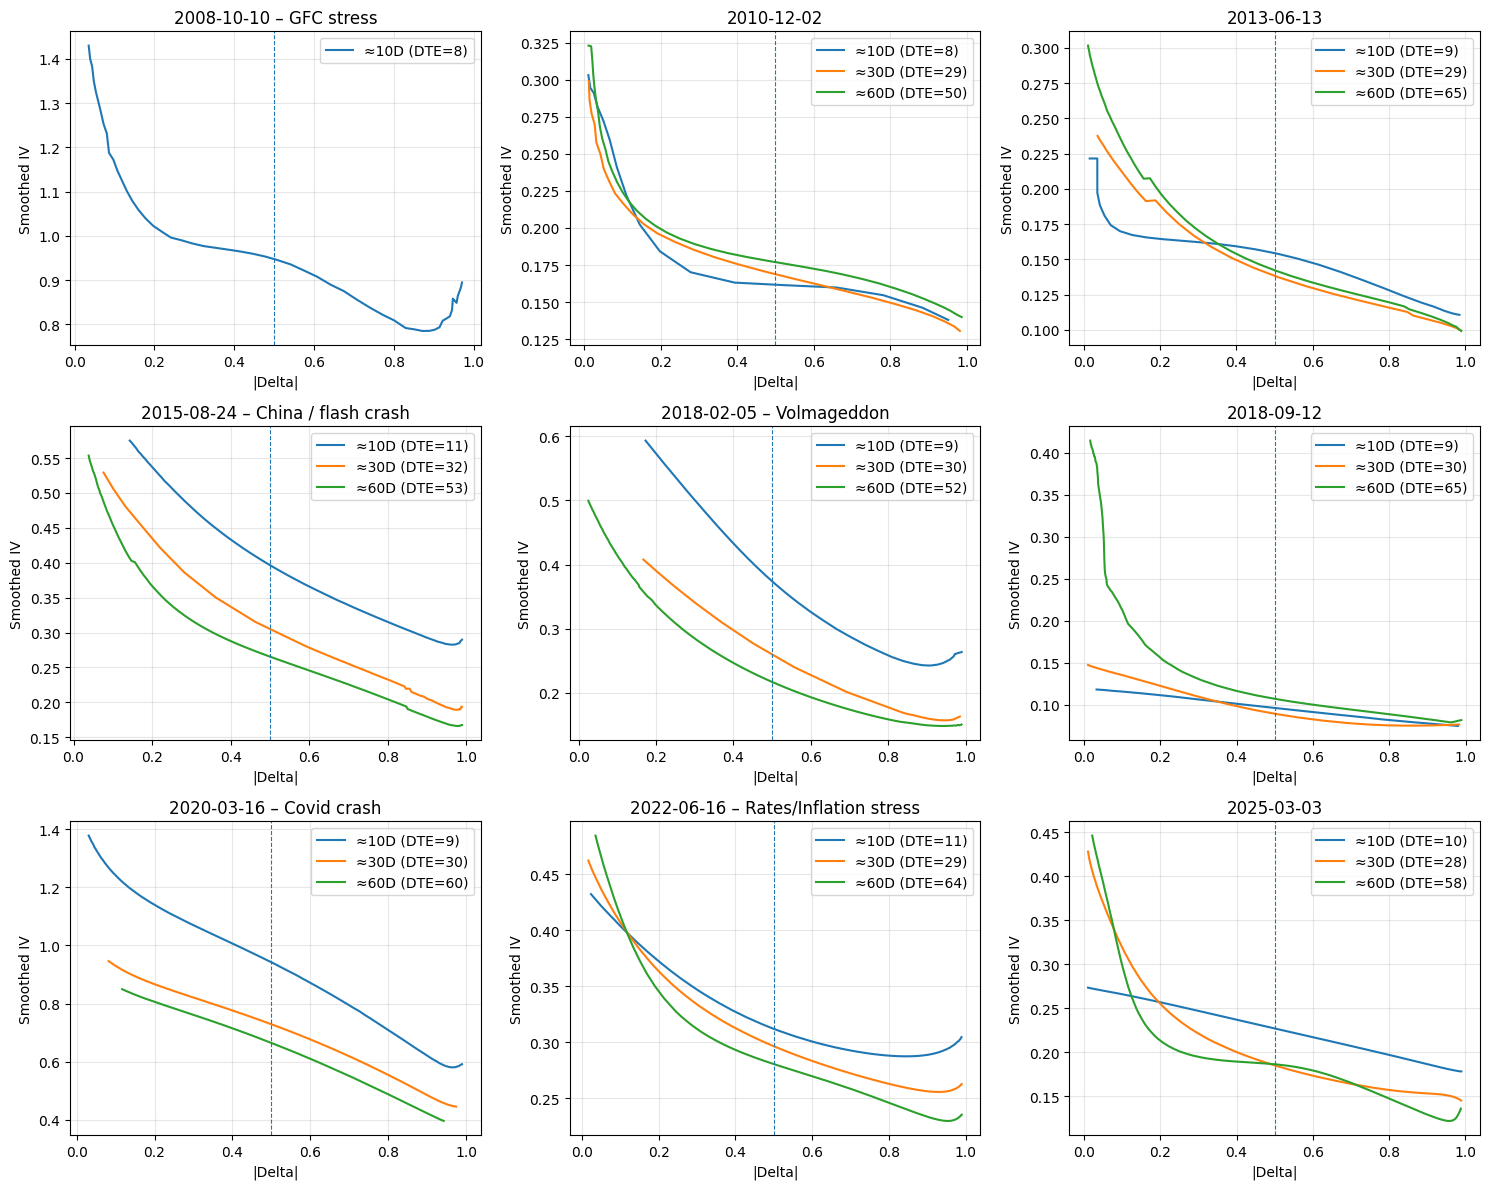

In [28]:
picked_dates = [
    date(2008, 10, 10),  # GFC
    date(2010, 12, 2),
    date(2013, 6, 13),
    date(2015, 8, 24),  # vol event
    date(2018, 2, 5),  # volmageddon
    date(2018, 9, 12),
    date(2020, 3, 16),  # covid crash
    date(2022, 6, 16),  # high vol / rates
    date(2025, 3, 3),
]

event_labels = {
    date(2008, 10, 10): "GFC stress",
    date(2015, 8, 24): "China / flash crash",
    date(2018, 2, 5): "Volmageddon",
    date(2020, 3, 16): "Covid crash",
    date(2022, 6, 16): "Rates/Inflation stress",
}

plot_smiles_by_delta(df, picked_dates=picked_dates, event_labels=event_labels)

The smootthed IV alreadu comes from a smoothed surface so a single linear interpolation between the reporetd strikes is enough and does not require any smoothing. Thus if we would request a particular striek we would jsut extratc the closest to the target.

## IV Term-Structure Shapes

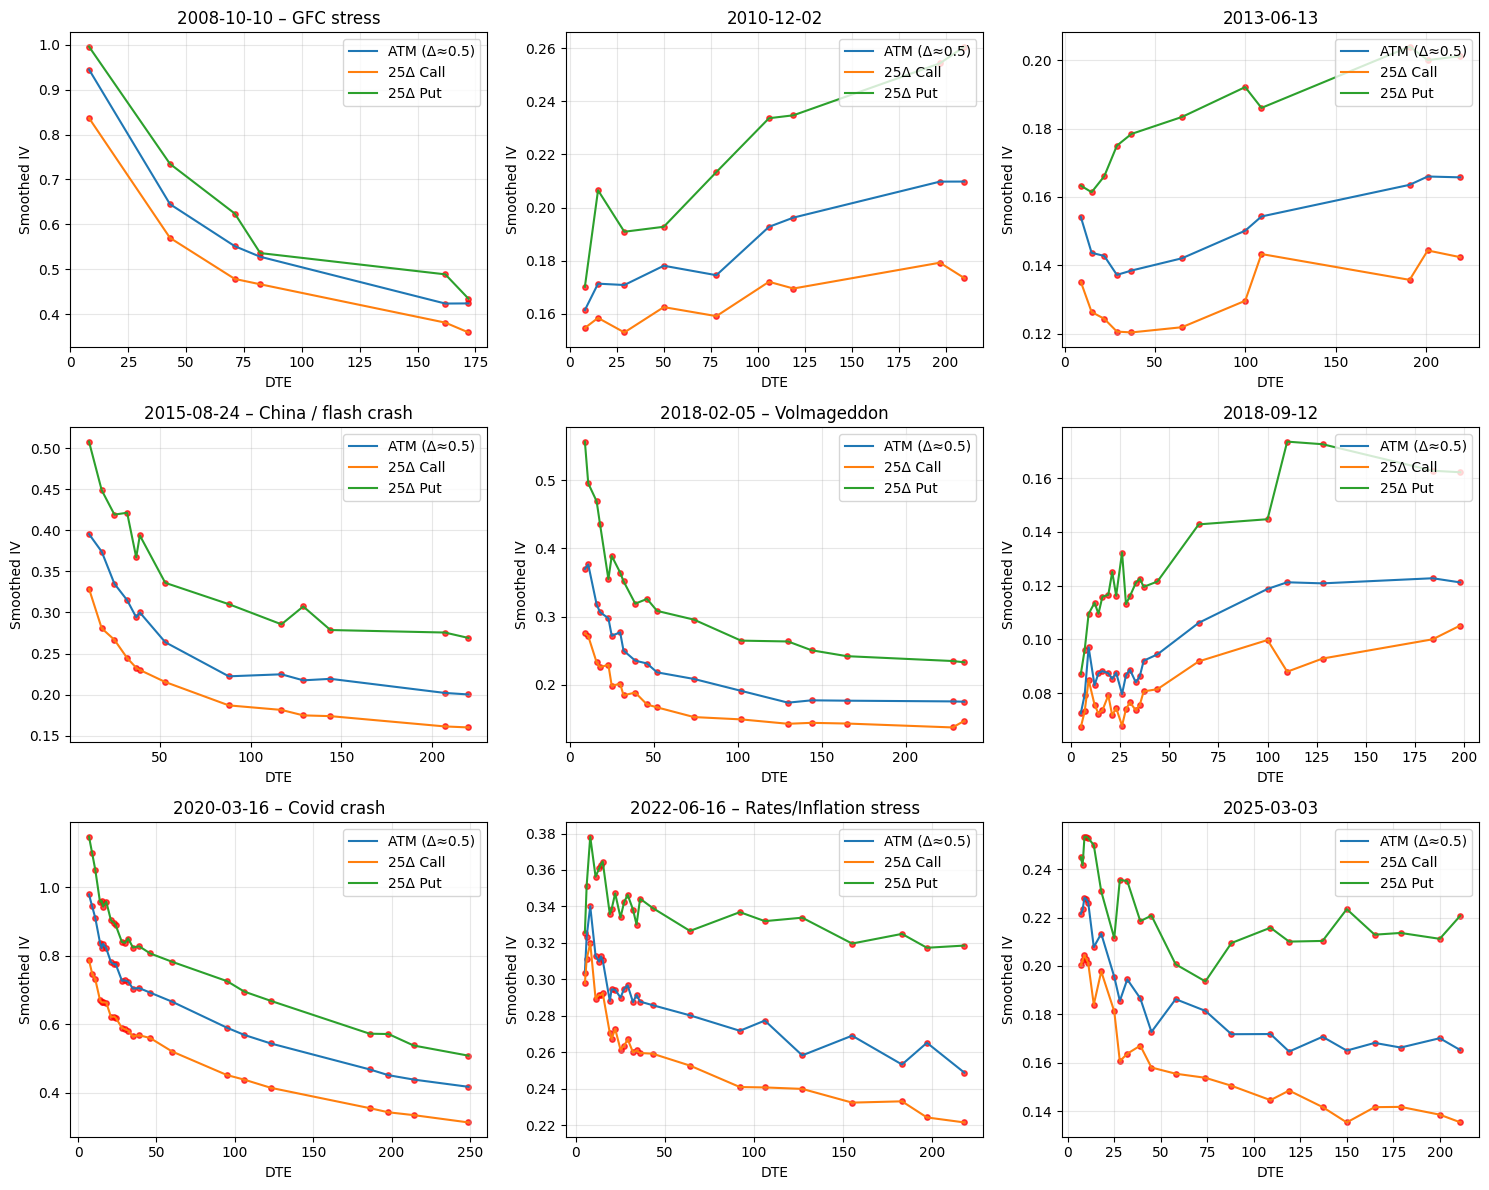

In [29]:
plot_term_structures_by_delta(df, picked_dates=picked_dates, event_labels=event_labels)

On crash dates the term strcutrue is inverted (in backwardation) while in normal regime it is upward sloping (in contango).

## Plot the IV time series like 30 DTE vs 15 vs 60 vs date

<Axes: xlabel='trade_date'>

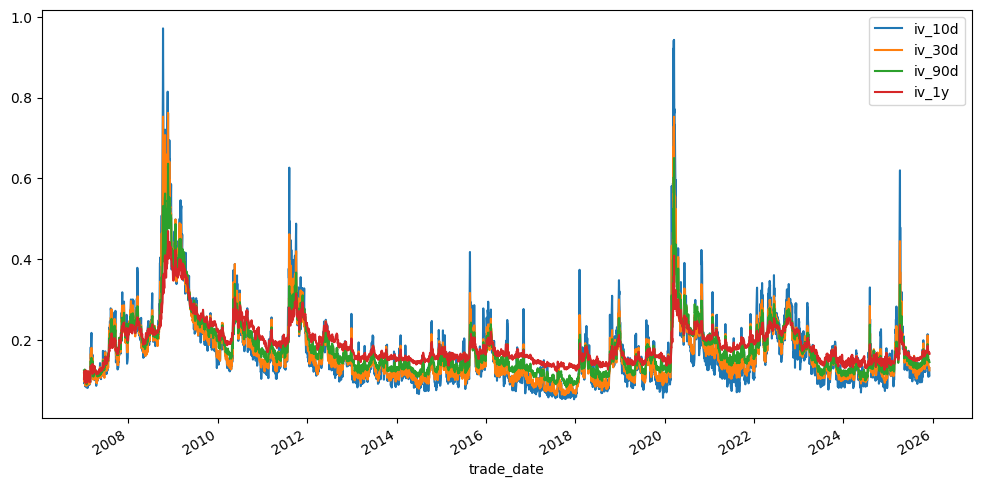

In [88]:
daily_features.loc[:, ["iv_10d", "iv_30d", "iv_90d","iv_1y"]].plot(figsize=(12, 6))

The shorter DTEs IV series are much more reactive than the larger ones espcailly the 1 y, especially durign crisis wher eteh risk is expected to be larger over the next few weeks wheres the larger oens like 1y still reacts but includes the future 1 year period thus includes the recovery expetced afetr the crisis happening over teh next few weeks.

# **Greeks Sanity Checks**


In [100]:
greeks_checks_cols = [
    "gamma_non_negative",
    "vega_non_negative",
    "GLOBAL_delta_bounds_sane_C",
    "GLOBAL_delta_bounds_sane_P",
    "ROI_delta_bounds_sane_C",
    "ROI_delta_bounds_sane_P",
    "GLOBAL_theta_positive_C",
    "GLOBAL_theta_positive_P",
    "ROI_theta_positive_C",
    "ROI_theta_positive_P",
]

qc_table(greeks_checks_cols)

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,null,i64,f64
"""gamma_non_negative""","""HARD""","""OK""",true,15073890,null,0,0.0
"""vega_non_negative""","""HARD""","""OK""",true,15073890,null,0,0.0
"""GLOBAL_delta_bounds_sane_C""","""SOFT""","""OK""",true,15073890,null,0,0.0
"""GLOBAL_delta_bounds_sane_P""","""SOFT""","""OK""",true,15073890,null,0,0.0
"""GLOBAL_theta_positive_C""","""SOFT""","""OK""",true,15073890,null,0,0.0
"""GLOBAL_theta_positive_P""","""SOFT""","""OK""",true,15073890,null,0,0.0
"""ROI_delta_bounds_sane_C""","""SOFT""","""OK""",true,2678530,null,0,0.0
"""ROI_delta_bounds_sane_P""","""SOFT""","""OK""",true,2678530,null,0,0.0
"""ROI_theta_positive_C""","""SOFT""","""OK""",true,2678530,null,0,0.0


In [101]:
qc_thresholds(greeks_checks_cols)

name,mild,warn,fail
str,f64,f64,f64
"""GLOBAL_delta_bounds_sane_C""",0.000001,0.00001,0.0001
"""GLOBAL_delta_bounds_sane_P""",0.000001,0.00001,0.0001
"""GLOBAL_theta_positive_C""",0.001,0.005,0.01
"""GLOBAL_theta_positive_P""",0.001,0.005,0.01
"""ROI_delta_bounds_sane_C""",0.000001,0.00001,0.0001
"""ROI_delta_bounds_sane_P""",0.000001,0.00001,0.0001
"""ROI_theta_positive_C""",0.001,0.005,0.01
"""ROI_theta_positive_P""",0.001,0.005,0.01


## Greeks vs Strike

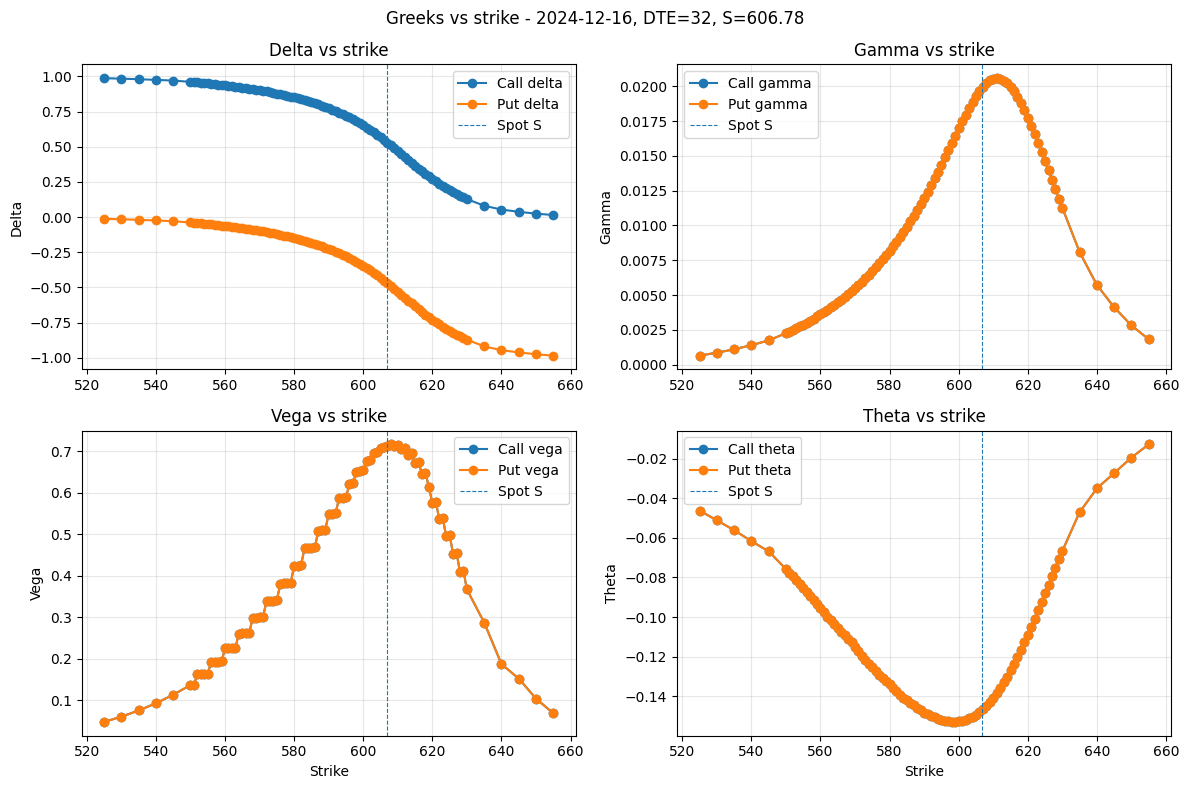

In [32]:
day = date(2024, 12, 16)
dte_target = 30

sub = df_long.filter(pl.col("trade_date") == day)
dtes_for_day = sub.select(pl.col("dte").unique()).sort("dte").to_series().to_list()

dte_true = pick_closest_dte(dtes_for_day, dte_target, max_tol=10)
if dte_true is None:
    raise ValueError(f"No DTE within 10 days of target={dte_target} on {day}")

sub = sub.filter(pl.col("dte") == dte_true).sort("strike")
S = sub.select("underlying_price").to_series().item(0)
calls = sub.filter(pl.col("option_type") == "C")
puts = sub.filter(pl.col("option_type") == "P")

fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=False)
ax_d, ax_g = axes[0]
ax_v, ax_t = axes[1]

plots = [
    ("delta", ax_d, "Delta", "Delta vs strike"),
    ("gamma", ax_g, "Gamma", "Gamma vs strike"),
    ("vega", ax_v, "Vega", "Vega vs strike"),
    ("theta", ax_t, "Theta", "Theta vs strike"),
]

for col, ax, ylabel, title in plots:
    ax.plot(calls["strike"], calls[col], label=f"Call {col}", marker="o")
    ax.plot(puts["strike"], puts[col], label=f"Put {col}", marker="o")
    ax.axvline(S, linestyle="--", linewidth=0.8, label="Spot S")
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.grid(True, alpha=0.3)
    ax.legend()

ax_v.set_xlabel("Strike")
ax_t.set_xlabel("Strike")
fig.suptitle(f"Greeks vs strike - {day}, DTE={dte_true}, S={S:.2f}")
fig.tight_layout()
plt.show()

# **Model-driven / arbitrage checks**

Before looking at theoretical arbitrage violations, it is important to
remember that **not all of the option chain is realistically tradable for us**.

- In practice we care mainly about:
  - **ATM options** (both calls and puts),
  - **OTM calls and puts**, and
  - some **deep OTM puts** (typically not below ~10-delta).
- Deep ITM options (|Δ| ≈ 1) are usually **not attractive for vol trading**:
  they behave almost like the underlying (delta ≈ ±1, other Greeks ≈ 0),
  so it is often cleaner to trade the underlying directly.

On the maturity side:

- Our horizon of interest is roughly **10–60 days to expiry**:
  - very short maturities (< 10 DTE) suffer from extreme time decay,
  - very long maturities (> 60 DTE) often have low VRP and liquidity is thinner.

Therefore:

- **Violations in far wings (very small or very large delta) and very short/long DTE
  are much less relevant** than violations inside our core tradable region
  (e.g. 10–90Δ, 10–60 DTE).

To make this concrete, we first visualise how **liquidity (volume / open interest)**
is distributed across moneyness and maturity.

## Volume for Calls/Puts by $\Delta$ Moneyness

/Users/anthony/VSCode/python_project/volatility_trading/src/volatility_trading/etl/orats/qc/plotting.py:225: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot = vol_by_delta.pivot_table(


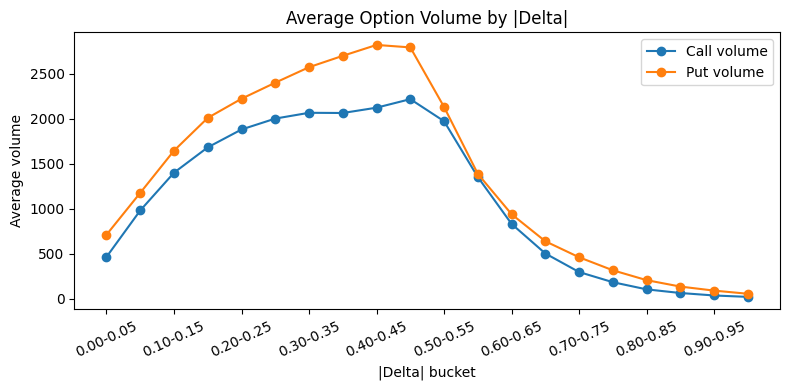

In [102]:
plot_avg_volume_by_delta(df_long)

Here it is obvious that deep OTM puts are much more traded than OTM calls and taht is because of hedging demand for large institutional investors and contrarian directional options invetsor who bet on a crahs to happen.

## Volume/Open Interest by DTE

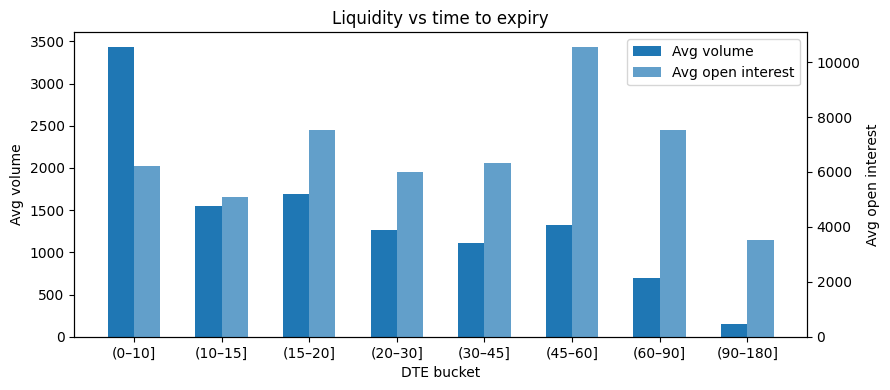

In [103]:
plot_liquidity_by_dte(df_long)

Here short maturities are much more traded wrt the open interest (the nb of oustandijgn contartcs currently in the market) but the larger we go in the DTEs the larger the OI and the lwoer the traded volume whihc also makes sense.

# **Put-Call Parity checks**

**Economic context (AOA):**
In frictionless markets, no-arbitrage implies a strict parity relation for
European options:

$$
C_E - P_E = S_0 e^{-qT} - K e^{-rT}.
$$

**Tradable arbitrage context:**
In live markets, we cannot trade at mid and we pay bid/ask costs. So a small
parity gap is often non-actionable. We therefore assess parity with a
spread-aware tolerance rather than as an exact equality.

## American parity check used in this QC

SPY options are American, so we use bounds (not equality):

$$
S_0 e^{-qT} - K \le C_A - P_A \le S_0 - K e^{-rT}.
$$

Using mid prices:

$$
L = C_{\text{mid}} - P_{\text{mid}}.
$$

Dynamic tolerance:

$$
\tau = \alpha\Big((C_{\text{ask}}-C_{\text{bid}}) + (P_{\text{ask}}-P_{\text{bid}})\Big) + \tau_0.
$$

In this pipeline, $\alpha = 1.0$ and $\tau_0 = 0.01$.
We flag a violation when:

$$
L < \text{lower} - \tau \quad \text{or} \quad L > \text{upper} + \tau.
$$

This is a SOFT data-quality diagnostic: high violations in ROI are more
concerning than violations concentrated in illiquid wings.

In [ ]:
pcp_checks_cols = [
    "GLOBAL_pcp_bounds_mid_am",
    "ROI_pcp_bounds_mid_am",
]

qc_table(pcp_checks_cols)

In [115]:
qc_top_buckets(pcp_checks_cols[0])

dte_bucket,delta_bucket,n_viol,n_rows,viol_rate_bucket,viol_share,row_share
str,str,i64,i64,f64,f64,f64
"""(0, 10]""","""(0.3, 0.7]""",14886,110331,0.134921,0.046816,0.014651
"""(30, 60]""","""(0.7, 0.9]""",30014,233861,0.128341,0.094394,0.031055
"""(30, 60]""","""(0.3, 0.7]""",26028,242655,0.107263,0.081858,0.032223
"""(10, 30]""","""(0.3, 0.7]""",28947,275071,0.105235,0.091038,0.036527
"""(10, 30]""","""(0.7, 0.9]""",29049,285256,0.101835,0.091359,0.03788


In [116]:
qc_top_buckets(pcp_checks_cols[1])

dte_bucket,delta_bucket,n_viol,n_rows,viol_rate_bucket,viol_share,row_share
str,str,i64,i64,f64,f64,f64
"""(0, 10]""","""(0.3, 0.7]""",2204,13349,0.165106,0.017535,0.009967
"""(0, 10]""","""(0.7, 0.9]""",1985,14087,0.14091,0.015793,0.010518
"""(30, 60]""","""(0.7, 0.9]""",30014,233854,0.128345,0.238792,0.174614
"""(30, 60]""","""(0.3, 0.7]""",26028,242655,0.107263,0.207079,0.181186
"""(10, 30]""","""(0.3, 0.7]""",28947,275071,0.105235,0.230303,0.20539


# **Arbitrage bounds for call & put prices**

Price-bound diagnostics from summary keys.

In [37]:
bounds_checks = qc_table(
    [
        "GLOBAL_price_bounds_mid_eu_forward_C",
        "GLOBAL_price_bounds_mid_eu_forward_P",
        "ROI_price_bounds_mid_eu_forward_C",
        "ROI_price_bounds_mid_eu_forward_P",
        "GLOBAL_price_bounds_mid_am_C",
        "GLOBAL_price_bounds_mid_am_P",
        "ROI_price_bounds_mid_am_C",
        "ROI_price_bounds_mid_am_P",
    ]
)
bounds_checks

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,null,i64,f64
"""GLOBAL_price_bounds_mid_am_C""","""SOFT""","""FAIL""",false,15073890,null,4095403,0.271689
"""GLOBAL_price_bounds_mid_am_P""","""SOFT""","""WARN""",false,15073890,null,2678940,0.177721
"""ROI_price_bounds_mid_am_C""","""SOFT""","""FAIL""",false,2678530,null,654689,0.244421
"""ROI_price_bounds_mid_am_P""","""SOFT""","""WARN""",false,2678530,null,394119,0.14714


In [38]:
bounds_global_put = first_existing(
    "GLOBAL_price_bounds_mid_eu_forward_P",
    "GLOBAL_price_bounds_mid_am_P",
)
if bounds_global_put is not None:
    qc_top_buckets(bounds_global_put).head(10)

## Strike & maturity monotonicity checks

Use SOFT monotonicity checks from qc summary.

In [39]:
monotonicity_checks = qc_table(
    [
        "GLOBAL_strike_monotonicity_C",
        "GLOBAL_strike_monotonicity_P",
        "ROI_strike_monotonicity_C",
        "ROI_strike_monotonicity_P",
        "GLOBAL_maturity_monotonicity_C",
        "GLOBAL_maturity_monotonicity_P",
        "ROI_maturity_monotonicity_C",
        "ROI_maturity_monotonicity_P",
    ]
)
monotonicity_checks

name,severity,grade,passed,n_rows,n_units,n_viol,viol_rate
str,str,str,bool,i64,null,i64,f64
"""GLOBAL_maturity_monotonicity_C""","""SOFT""","""OK""",true,15073890,null,126491,0.008391
"""GLOBAL_maturity_monotonicity_P""","""SOFT""","""MILD""",true,15073890,null,351111,0.023293
"""GLOBAL_strike_monotonicity_C""","""SOFT""","""OK""",true,15073890,null,17039,0.00113
"""GLOBAL_strike_monotonicity_P""","""SOFT""","""OK""",true,15073890,null,13667,0.000907
"""ROI_maturity_monotonicity_C""","""SOFT""","""OK""",true,2678530,null,1750,0.000653
"""ROI_maturity_monotonicity_P""","""SOFT""","""OK""",true,2678530,null,2917,0.001089
"""ROI_strike_monotonicity_C""","""SOFT""","""OK""",true,2678530,null,256,0.000096
"""ROI_strike_monotonicity_P""","""SOFT""","""OK""",true,2678530,null,411,0.000153


In [40]:
qc_top_buckets("GLOBAL_strike_monotonicity_P").head(10)

dte_bucket,delta_bucket,n_viol,n_rows,viol_rate_bucket,viol_share,row_share
str,str,i64,i64,f64,f64,f64
"""(10, 30]""","""(-inf, 0]""",1786,111212,0.016059,0.13068,0.014756
"""(0, 10]""","""(-inf, 0]""",4538,310018,0.014638,0.332041,0.041133
"""(30, 60]""","""(-inf, 0]""",171,21540,0.007939,0.012512,0.002858
"""(0, 10]""","""(0, 0.05]""",2333,386997,0.006028,0.170703,0.051347
"""(10, 30]""","""(0, 0.05]""",2130,393513,0.005413,0.15585,0.052211


In [41]:
qc_top_buckets("GLOBAL_maturity_monotonicity_P").head(10)

dte_bucket,delta_bucket,n_viol,n_rows,viol_rate_bucket,viol_share,row_share
str,str,i64,i64,f64,f64,f64
"""(10, 30]""","""(0.95, 1]""",107155,428723,0.24994,0.305188,0.056883
"""(0, 10]""","""(0.95, 1]""",108660,459052,0.236705,0.309475,0.060907
"""(30, 60]""","""(0.95, 1]""",49471,231335,0.21385,0.140898,0.030693
"""(60, 180]""","""(0.95, 1]""",49639,278094,0.178497,0.141377,0.036897
"""(180, inf]""","""(0.95, 1]""",6371,56771,0.112223,0.018145,0.007532
